In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import uproot,glob


plt.rcParams["figure.figsize"] = (10, 8)


In [2]:
from scipy.optimize import curve_fit

def gauss(x, A,mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def res_plot(a, fnc=gauss, bins=None, label=None, unit=" mm", legend=True, eb_args={}, fitcurve_args={}, nsigma=2):
    a=np.array(a)
    mean=np.mean(a)
    sigma=np.std(a)
    if bins is None :
        bins = np.linspace(mean-3*sigma,mean+3*sigma, 20)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    eb=plt.errorbar(bc, h, np.sqrt(h), ls='', label=label,**eb_args)
    curve=None
    a_in_window=a[(a>=x[0])&(a<=x[-1])]
    p0=[10,0, np.std(a_in_window)*.9]
    slc=np.abs(bc-np.mean(a_in_window))<nsigma*np.std(a_in_window)
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        print(f"fit: $\\sigma={coeff[2]:.1f}\\pm{np.sqrt(var_matrix[2][2]):.1f}${unit}")
        x=np.linspace(x[0], x[-1], 100)
        
        digits=1 if np.sqrt(var_matrix[2][2])>0.1 else 2
        if coeff[2]< 1000 and var_matrix[2][2]<1000:
            curve=plt.plot(x, fnc(x,*coeff), label=f"fit: $\\sigma={abs(coeff[2]):.{digits}f}\\pm {np.sqrt(var_matrix[2][2]):.{digits}f}${unit}",
                          **fitcurve_args)
        if legend:
            plt.legend(loc='upper left', fontsize=20)
        return coeff[2],np.sqrt(var_matrix[2][2]), eb, curve
    except:
        return 0, 0, eb, None
    

In [3]:
#do just the calculation of the resolution
def res_calc(a, fnc=gauss, bins=None, nsigma=2):
    a=np.array(a)
    mean=np.mean(a)
    sigma=np.std(a)
    if bins is None :
        bins = np.linspace(mean-3*sigma,mean+3*sigma, 20)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    a_in_window=a[(a>=x[0])&(a<=x[-1])]
    p0=[10,0, np.std(a_in_window)*.9]
    slc=np.abs(bc-np.mean(a_in_window))<nsigma*np.std(a_in_window)
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        return abs(coeff[2]),np.sqrt(var_matrix[2][2])
    except:
        return 0, 0

dr
fit: $\sigma=11.8\pm0.6$ mm
dr
fit: $\sigma=11.5\pm0.8$ mm
dr_rw
fit: $\sigma=-12.7\pm0.7$ mm
dr
fit: $\sigma=12.2\pm0.5$ mm
dr_rw
fit: $\sigma=19.6\pm2.3$ mm


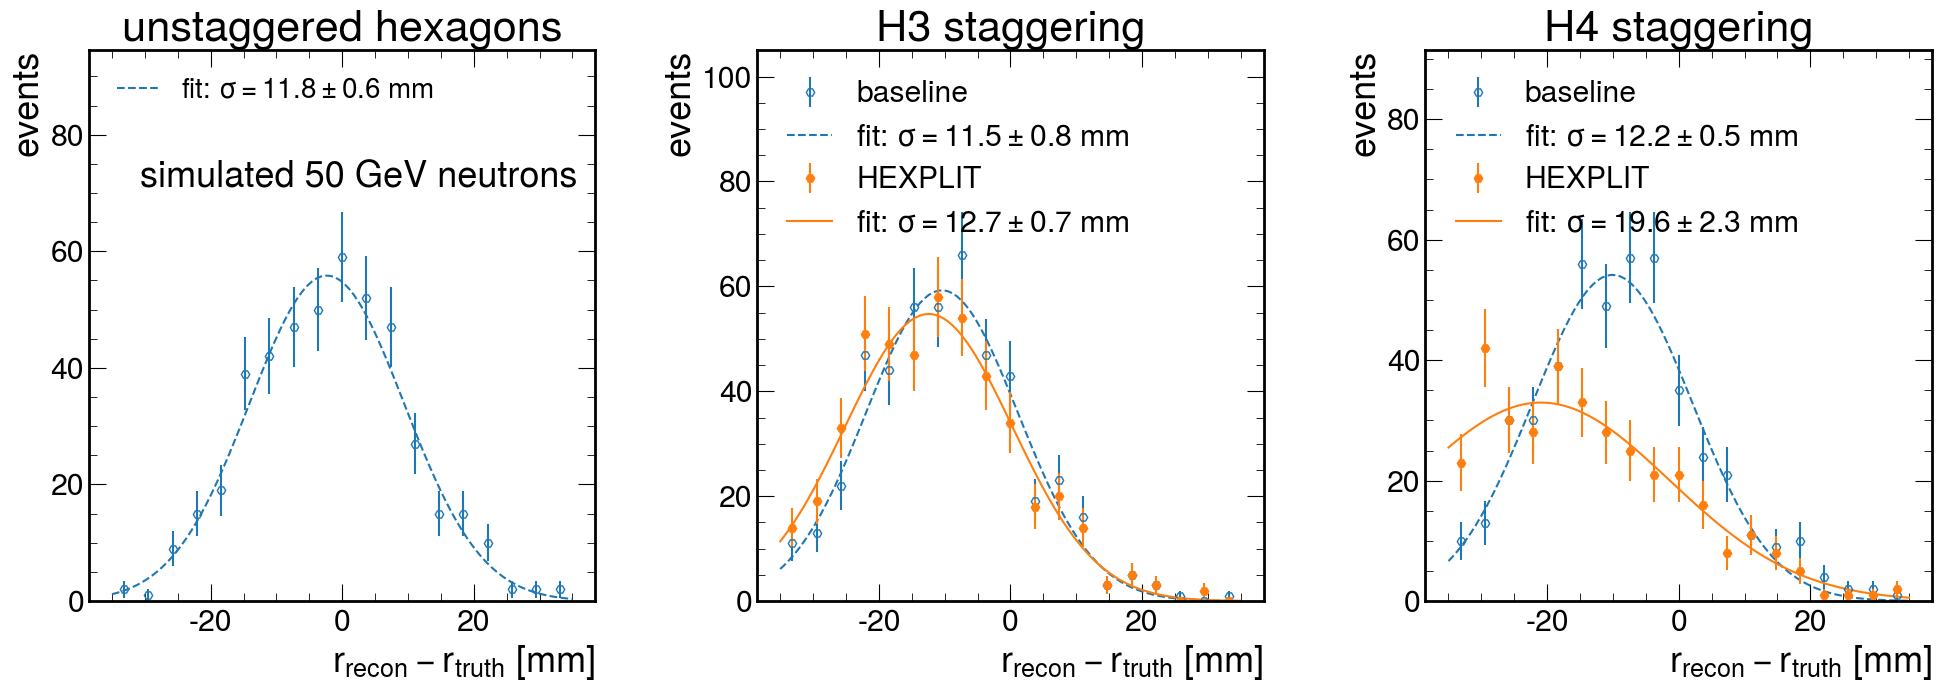

In [30]:

arg_w0=dict(min_w0=3.5, max_w0=7)
def plots_1d(Ebeam, bins=np.linspace(-80, 80, 25), particle="neutron", nsigma=2):
    field_nrw="dr"
    field_rw="dr_rw"
    fig,axs=plt.subplots(1,3, figsize=(20,7.5))
    q="abs(x_truth)<2500 and abs(y_truth)<2500"
    plt.sca(axs[0])
    plt.title("unstaggered hexagons")
    
    # Approach using map() function.
    path=f'dd4hep/zdc_unstaggered_inf_reco_{particle}_{Ebeam}GeV_theta_deg.edm4hep.root_lin.csv'
    df = pd.read_csv(path)
    #print(df.columns)
    df =df.query(q)
    
    
    field=field_nrw
    print(field)
    #print(best_field)
    res,dres, eb, curve= res_plot(df[field], bins=bins, 
                                  label=None,eb_args=dict(color='tab:blue', fillstyle='none', marker='H'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'),nsigma=nsigma)
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")


    plt.sca(axs[1])
    plt.title("H3 staggering")
    path=f'dd4hep/zdc_staggered_h3_inf_reco_{particle}_{Ebeam}GeV_theta_deg.edm4hep.root_lin.csv'
    df = pd.read_csv(path)
    #print(df.columns)
    df=df.query(q)
    
    
    field=field_nrw
    
    print(field)
    res,dres, eb1, curve1= res_plot(df[field], bins=bins, 
                                  label="baseline", legend=False,eb_args=dict(color='tab:blue', fillstyle='none', marker='H'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'),nsigma=nsigma)
    #field=w0_scan(df, field_rw, bins, **arg_w0)
    
    field=field_rw
    print(field)
    res,dres, eb2, curve2= res_plot(df[field], bins=bins, 
                                  label="HEXPLIT", legend=False, eb_args=dict(color='tab:orange', fillstyle='full', marker='H'),
                                   fitcurve_args=dict(color='tab:orange', linestyle='-'),nsigma=nsigma)
    if curve2 is not None:
        plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    else : 
        plt.legend(handles=[eb1, curve1[0]])
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    plt.sca(axs[2])
    plt.title("H4 staggering")
    
    path=f'dd4hep/zdc_staggered_h4_inf_reco_{particle}_{Ebeam}GeV_theta_deg.edm4hep.root_lin.csv'
    df = pd.read_csv(path).query(q)
    #field=w0_scan(df, field_nrw, bins,**arg_w0)
    
    field=field_nrw
    print(field)
    res,dres, eb1, curve1= res_plot(df[field], bins=bins, 
                                  label="baseline", legend=False,eb_args=dict(color='tab:blue', fillstyle='none', marker='H'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'),nsigma=nsigma)
    
    #
    field=field_rw
    print(field)
    res,dres, eb2, curve2= res_plot(df[field], bins=bins, 
                                  label="HEXPLIT", legend=False, eb_args=dict(color='tab:orange', fillstyle='full', marker='H'),
                                   fitcurve_args=dict(color='tab:orange', linestyle='-'),nsigma=nsigma)

    if curve2 is not None:
        plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    else : 
        plt.legend(handles=[eb1, curve1[0]])
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    axs[0].text(0.1, 0.75, f"simulated {Ebeam} GeV {particle}s", transform=axs[0].transAxes)

    for ax in axs:
        ax.set_ylabel("events")
        ax.set_ylim(0, ax.get_ylim()[1]*1.35)


    plt.tight_layout()
    plt.savefig(f"images/zdc_results_1d_{Ebeam}_GeV_{particle}_lin.pdf")
    plt.show()
#plots_1d(10) 
plots_1d(50, bins=np.linspace(-35,35, 20), particle="neutron", nsigma=2) 
# plots_1d(50, bins=np.linspace(-8,8, 20), particle="gamma", nsigma=2) 
# plots_1d(20, bins=np.linspace(-11,11, 20), particle="gamma", nsigma=3) 
# plots_1d(10, bins=np.linspace(-10,10, 20), particle="gamma", nsigma=3) 
# plots_1d(100, bins=np.linspace(-6,6, 20), particle="gamma", nsigma=3) 
# plots_1d(200, bins=np.linspace(-6,6, 20), particle="gamma", nsigma=3)
# plots_1d(275, bins=np.linspace(-5,5, 20), particle="gamma", nsigma=3)
#plots_1d(100, bins=np.linspace(-30,30, 20)) 
#plots_1d(20, bins=np.linspace(-40,40, 20)) 
#plots_1d(100, bins=np.linspace(-50,50, 25)) 

In [259]:
# def shift_recon(df, val):
#     for field in df.columns:
#         if "dr_w0" in field:
#             w0=field.split("_")[-1]
#             df[field] = df.eval(f"sqrt((dx_w0_{w0}+x_truth_w0_{w0}+{val})**2+(dy_w0_{w0}+y_truth_w0_{w0}+{val})**2)"+\
#                                 f"-sqrt((x_truth_w0_{w0})**2+(y_truth_w0_{w0})**2)")
#         elif "dr_rw_w0" in field:
#             w0=field.split("_")[-1]
#             df[field] = df.eval(f"sqrt((dx_rw_w0_{w0}+x_truth_w0_{w0}+{val})**2+(dy_rw_w0_{w0}+y_truth_w0_{w0}+{val})**2)"+\
#                                 f"-sqrt((x_truth_w0_{w0})**2+(y_truth_w0_{w0})**2)")   
            

dr_w0_5pt5
fit: $\sigma=10.9\pm0.6$ mm
dr_w0_6pt75
fit: $\sigma=9.7\pm0.3$ mm
dr_rw_w0_4pt75
fit: $\sigma=-6.7\pm0.5$ mm


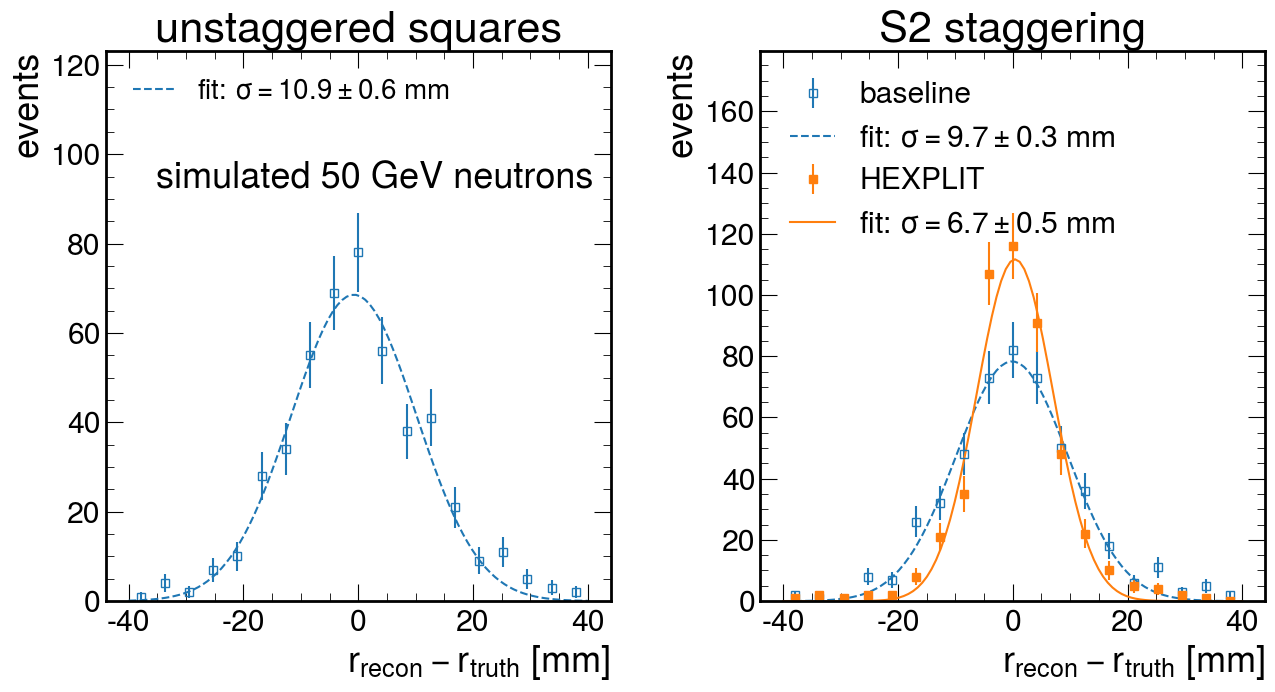

In [264]:

def plots_1d_square(Ebeam, bins=np.linspace(-80, 80, 25)):
    field_nrw='dr'
    field_rw='dr_rw'
    fig,axs=plt.subplots(1,2, figsize=(20*2/3,7.5))
    q="abs(x_truth_w0_4pt0)<2500 and abs(y_truth_w0_4pt0)<2500"
    plt.sca(axs[0])
    plt.title("unstaggered squares")
    
    path=f'dd4hep/zdc_s1_inf_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    df = pd.read_csv(path)
    df =df.query(q)
    
    field=w0_scan(df, field_nrw, bins, **arg_w0)
    print(field)
    res,dres, eb, curve= res_plot(df[field], bins=bins, 
                                  label=None,eb_args=dict(color='tab:blue', fillstyle='none', marker='s'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'))
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")


    plt.sca(axs[1])
    plt.title("S2 staggering")
    path=f'dd4hep/zdc_s2_inf_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root.csv'

    #path=f'dd4hep/zdc_s2_inf_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    df = pd.read_csv(path)
    #shift_recon(df, 31.3*np.sqrt(3*np.sqrt(3)/2)*.25)
    #print(df.columns)
    df=df.query(q)
    
    field=w0_scan(df, field_nrw, bins, **arg_w0)
    print(field)
    res,dres, eb1, curve1= res_plot(df[field], bins=bins, 
                                  label="baseline", legend=False,eb_args=dict(color='tab:blue', fillstyle='none',
                                                                                   marker='s'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'))
    field=w0_scan(df, field_rw, bins, **arg_w0)
    print(field)
    res,dres, eb2, curve2= res_plot(df[field], bins=bins, 
                                   label="HEXPLIT", legend=False, eb_args=dict(color='tab:orange', fillstyle='full', 
                                                                                 marker='s'),
                                    fitcurve_args=dict(color='tab:orange', linestyle='-'))
    
    plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    #plt.legend(handles=[eb1, curve1[0]], loc='upper left')
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    
    axs[0].text(0.1, 0.75, f"simulated {Ebeam} GeV neutrons", transform=axs[0].transAxes)

    for ax in axs:
        ax.set_ylabel("events")
        ax.set_ylim(0, ax.get_ylim()[1]*1.35)


    plt.tight_layout()
    plt.savefig(f"images/zdc_results_1d_{Ebeam}_GeV_squares.pdf")
    plt.show()
plots_1d_square(50, bins=np.linspace(-40,40, 20))

In [270]:


w0s_used={}
pos_res={}
dpos_res={}
Ebeams={}

for particle in "neutron", "gamma":
    w0s_used[particle]=[[] for i in range(5)]
    pos_res[particle]=[[] for i in range(5)]
    dpos_res[particle]=[[]for i in range(5)]
    Ebeams[particle]=[[]for i in range(5)]

    energies=10, 20, 50, 100, 200, 275

    q="abs(x_truth_w0_4pt0)<250 and abs(y_truth_w0_4pt0)<250"

    windows={"neutron":[55,40,35,30, 16,12],"gamma":[10,10,10,6, 6,5]}
    for i in range(len(energies)):
        E=energies[i]
        bins=np.linspace(-windows[particle][i], windows[particle][i], 20)
        for j, (geo, field,key) in enumerate([("unstaggered","dr", "H1"), 
                                        ("staggered_h3", "dr", "H3_nrw"),
                                        ("staggered_h4", "dr", "H4_nrw"),
                                        ("staggered_h3", "dr_rw", "H3_rw"),
                                        ("staggered_h4", "dr_rw", "H4_rw")]):
            path=f'dd4hep/with_cuts/zdc_{geo}_inf_reco_{particle}_{E}GeV_theta_deg.edm4hep.root.csv'
            #if len(glob.glob(path)) == 0:
            #    path=f'dd4hep/zdc_{geo}_reco_neutron_{E}GeV_theta_deg.edm4hep.root.csv'
            if len(glob.glob(path)) != 0:
                df = pd.read_csv(path)
                df=df.query(q)
                #field=w0_scan(df, field, bins=bins, min_w0=3.5)
                w0 = w0_params[key][0]+np.log(E)*w0_params[key][1] if particle == "neutron" \
                            else w0_params_photon[key][0]+np.log(E)*w0_params_photon[key][1]
                w0=np.round(w0*4)/4
                field=field+f"_w0_{w0}".replace(".", "pt")
                w0s_used[particle][j].append(float(field.split("_")[-1].replace("pt", ".")))
                s, ds= res_calc(df[field], fnc=gauss, bins=bins)
                Ebeams[particle][j].append(E)
                pos_res[particle][j].append(s)
                dpos_res[particle][j].append(ds)
            else:
                #add dummy values to avoid crashing
                Ebeams[particle][j].append(E)
                pos_res[particle][j].append(-1)
                dpos_res[particle][j].append(-1)
    Ebeams[particle] = [np.array(e) for e in Ebeams[particle]]
    pos_res[particle] = [np.array(e) for e in pos_res[particle]]
    dpos_res[particle]= [np.array(e) for e in dpos_res[particle]]
print(dpos_res)

{'neutron': [array([0.70046509, 0.86831653, 0.62767374, 0.42530608, 0.08855437,
       0.27364347]), array([1.29486841, 1.38282436, 0.91070298, 0.37174806, 0.18601188,
       0.09827606]), array([1.55622244, 0.76152079, 0.89524927, 0.3656912 , 0.19189559,
       0.0888865 ]), array([0.69226945, 0.52093597, 0.44853097, 0.13072319, 0.17203959,
       0.22228465]), array([0.90164302, 0.58957818, 0.19837418, 0.07629999, 0.05614705,
       0.07518223])], 'gamma': [array([0.29801748, 0.17917694, 0.15641302, 0.13011816, 0.05224088,
       0.08377201]), array([0.13342298, 0.07581482, 0.1054706 , 0.08105294, 0.05035452,
       0.04014489]), array([0.09496289, 0.10516156, 0.02919767, 0.0502679 , 0.04617822,
       0.07703604]), array([0.15888121, 0.11645129, 0.11604482, 0.11523097, 0.01944808,
       0.04662878]), array([0.05251944, 0.12767211, 0.04595567, 0.02591684, 0.05294344,
       0.03344638])]}


[ 10.  20.  50. 100. 200. 275.] [22.61393658 15.08753584 10.05206531  7.3405688   5.01198062  4.4237868 ]
[ 10.2  20.4  51.  102.  204.  280.5] [19.86581482 15.76968078 10.25519923  5.62307137  3.37879396  2.83326583]
[ 10.4  20.8  52.  104.  208.  286. ] [20.78410643 12.38809665  8.27809667  4.56285441  2.58560023  2.12693559]
[ 10.6  21.2  53.  106.  212.  291.5] [13.61932154  9.77385322  5.70161903  4.47266053  3.53854783  2.80666745]
[ 10.8  21.6  54.  108.  216.  297. ] [13.18029238  8.81351838  4.93609683  3.337294    2.44810978  1.91201757]


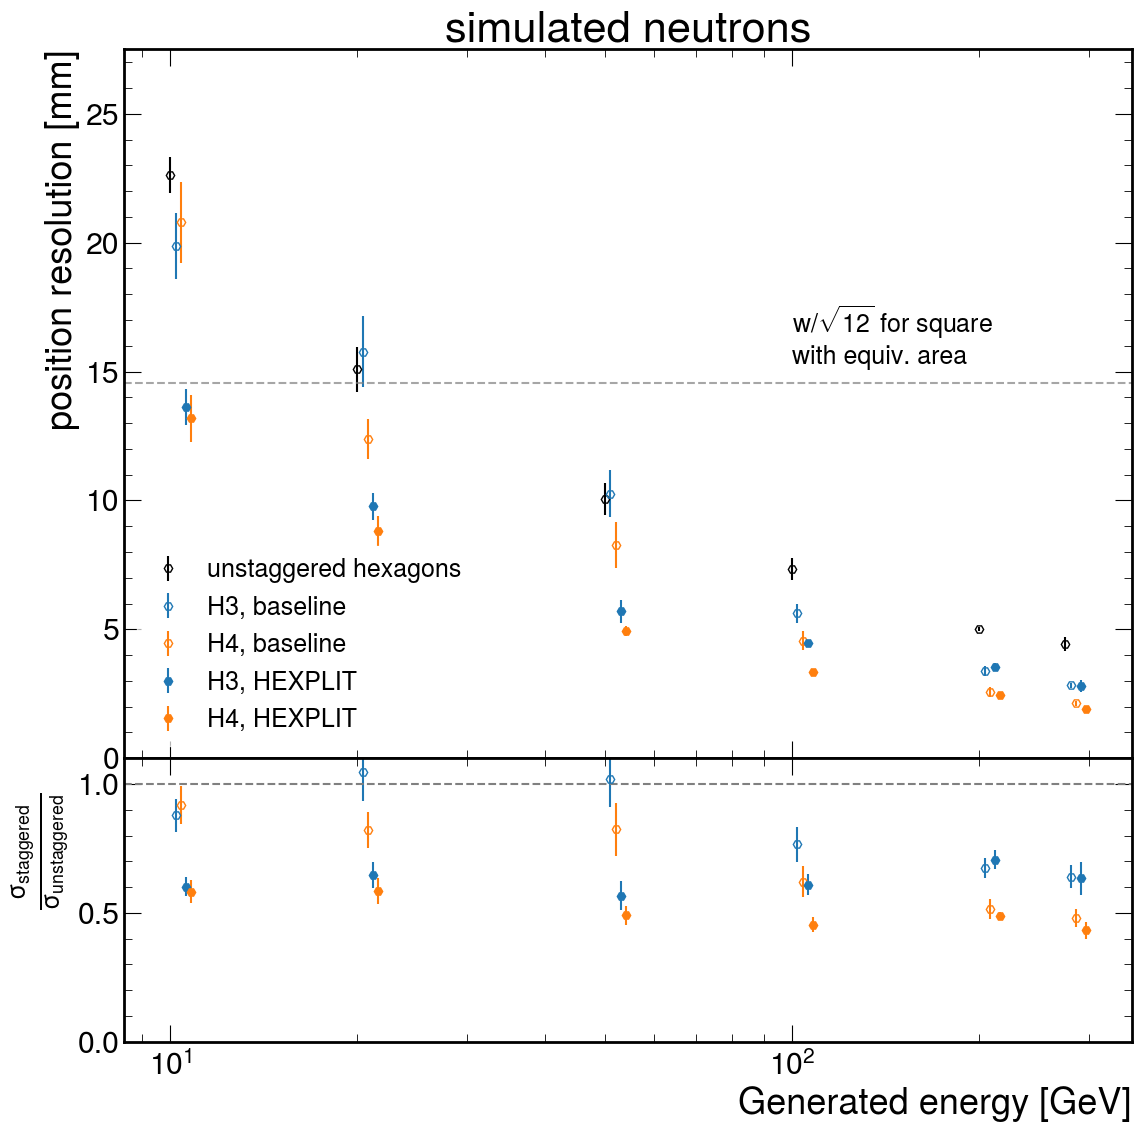

[ 10.  20.  50. 100. 200. 275.] [3.82886601 3.53618065 2.41544849 1.94652844 1.50715878 1.33903925]
[ 10.2  20.4  51.  102.  204.  280.5] [2.92927036 2.54755624 1.91542788 1.41920517 0.88195312 0.87734345]
[ 10.4  20.8  52.  104.  208.  286. ] [2.03773496 1.65971302 1.2718182  0.84704533 0.74635622 0.74889775]
[ 10.6  21.2  53.  106.  212.  291.5] [2.85647382 2.40727702 2.1485931  1.52308856 1.12011481 0.89598993]
[ 10.8  21.6  54.  108.  216.  297. ] [2.26130616 1.94344004 1.44771732 1.0864098  0.84519152 0.63780131]


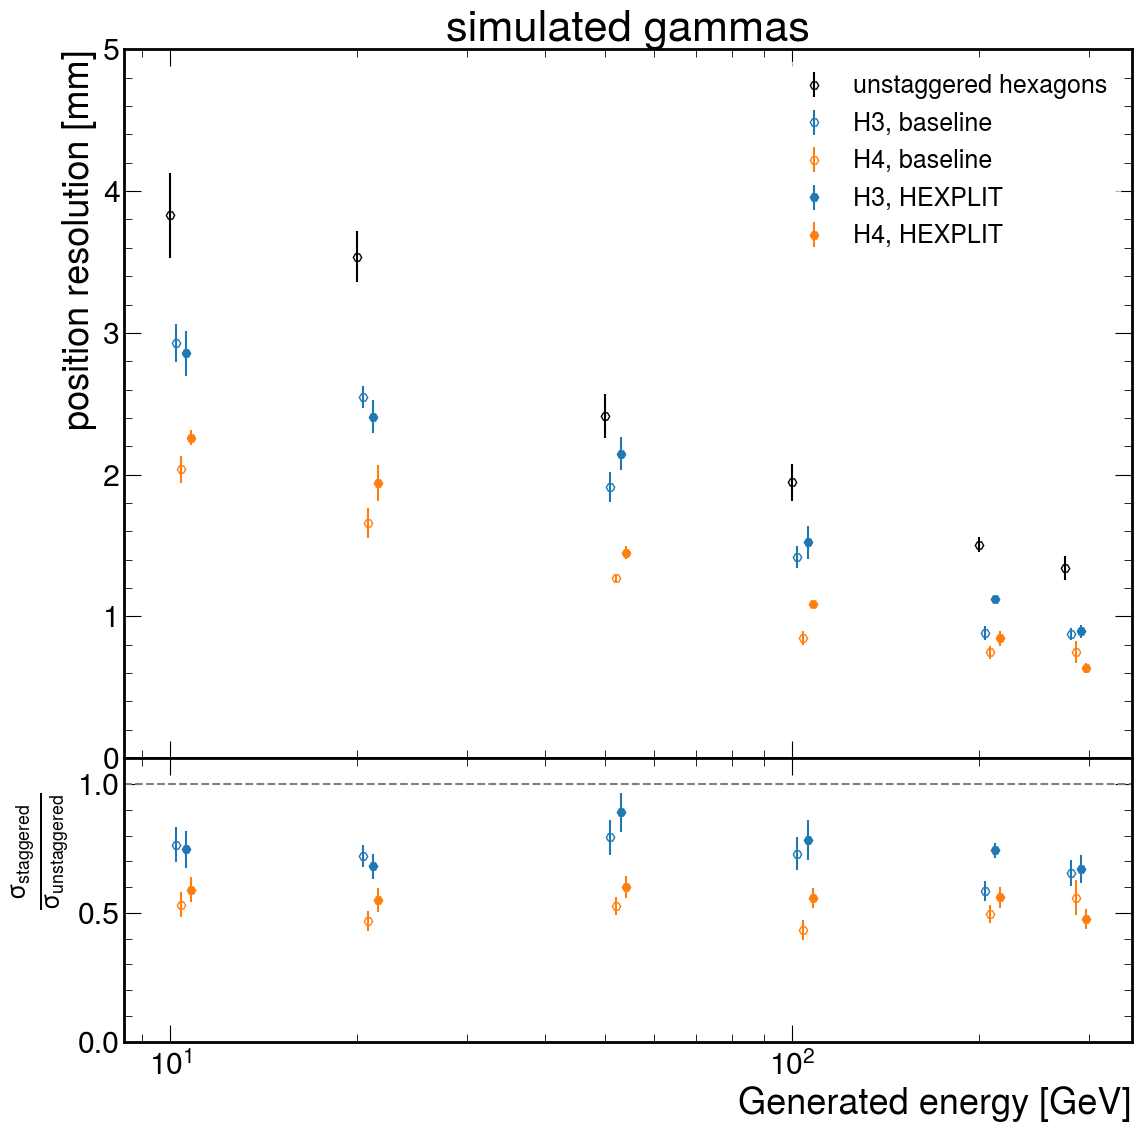

In [271]:
for particle in "neutron", "gamma":
    forZDCPaper=False
    z_in_meters=37.5


    labels="unstaggered hexagons", "H3, baseline", "H4, baseline", "H3, HEXPLIT", "H4, HEXPLIT",
    #pos_res=[r_res_vals_h1, r_res_vals_h3_no_rw, r_res_vals_h4_no_rw, r_res_vals_h3]
    #dpos_res=[r_res_errs_h1, r_res_errs_h3_no_rw, r_res_errs_h4_no_rw, r_res_errs_h3]
    #pos_res=[r_res_vals_h1, r_res_vals_h3_no_rw, None, r_res_vals_h3_rw]
    #dpos_res=[r_res_errs_h1, r_res_errs_h3_no_rw, None, r_res_errs_h3_rw]
    #Ebeams=[[10, 20, 50, 100, 150, 200, 275]]+[[1,2, 5, 10, 20, 30,40,50, 60, 70, 80, 90, 100]]*4

    cols={"H1":"k", "H3": "tab:blue", "H4": "tab:orange"}
    colors=[cols['H1'], cols['H3'], cols['H4'], cols['H3'], cols['H4']]
    fillstyles=['none', 'none', 'none', 'full', 'full']
    markers=['H', 'H', 'H', 'H', 'H']
    a=0.4
    fig, axs= plt.subplots(2,1, gridspec_kw=dict(height_ratios=(1,a)),sharex='all', figsize=(12, 8.5*(1+a)))
    artists=[]
    shift=0.02
    for i in range(5):

        y=pos_res[particle][i]
        dy=np.array(dpos_res[particle][i])
        x=np.array(Ebeams[particle][i])*(1+shift*i)
        print(x,y)
        a=axs[0].errorbar(x, y, dy, marker=markers[i], label=f'{labels[i]}', ls='', fillstyle=fillstyles[i], color=colors[i])
        artists.append(a)
        if i==0:
            y_ref=y
            dy_ref=dy
        else:
            slc=y>0
            axs[1].errorbar(Ebeams[particle][i][slc]*(1+shift*i), (y/y_ref)[slc], (y/y_ref*np.hypot(dy/y, dy_ref/y_ref))[slc], marker=markers[i], ls='', fillstyle=fillstyles[i], color=colors[i])
    

    import matplotlib as mpl, matplotlib.pyplot as plt
    from matplotlib.ticker import MultipleLocator, LogLocator, NullLocator, AutoMinorLocator, NullFormatter


    locminX = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    axs[0].set_xscale("log")
    axs[0].xaxis.set_minor_locator(locminX)

    axs[0].set_ylabel("position resolution [mm]")
    axs[1].set_ylabel("$\\frac{\\sigma_{staggered}}{\\sigma_{\\rm unstaggered}}$    ")
    axs[1].set_xlabel("Generated energy [GeV]")

    if particle=="neutron":
        maxy=27.5
        axs[0].set_ylim(0,maxy)
    else:
        axs[0].set_ylim(0,5)

    if forZDCPaper:
        ax2=axs[0].twinx()
        ax2.xaxis.set_minor_locator(locminX)
        ax2.set_ylim(0, maxy/z_in_meters)
        ax2.set_ylabel("$\\theta$ resolution [mrad]")

        a=axs[0].plot(x, 3/np.sqrt(x)*z_in_meters, label="YR requirement: $\\frac{3.0}{\\sqrt{E}}$ mrad", ls='--', color='tab:green')
        artists.append(a[0])

    axs[1].axhline(1,color='0.5', alpha=1, ls='--')

    axs[1].set_ylim(0)
    axs[0].set_xscale('log')

    if particle == "neutron":
        s=31.3
        A=s**2*np.sqrt(3)*3/2
        axs[0].axhline(np.sqrt(A)/np.sqrt(12),color='0.5', alpha=0.7, ls='--')
        axs[0].text(100, 1.05*np.sqrt(A)/np.sqrt(12), "w/$\\sqrt{12}$ for square\nwith equiv. area", fontsize=18,
                   zorder=10)

    #add a dummy artist so that there are 5 entries in a column
    #for i in range(2):
    #    a=axs[0].plot([],[],color='w', label='   ')
    #    artists.append(a[0])

    axs[0].legend(handles=artists,fontsize=18, ncol=1, framealpha=0.7, frameon=True,
                 edgecolor='w', loc='lower left' if particle=="neutron" else "upper right")
    axs[1].set_ylim(0,1.1)
    #maxy=axs[0].get_ylim()[1]
    if forZDCPaper:
        axs[0].set_title("ZDC simulated neutrons")
    else:
        axs[0].set_title(f"simulated {particle}s")
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.savefig(f"images/position_resolution_{particle}.pdf")
    plt.show()

In [67]:
print(w0s_used)

{'neutron': [[5.5, 5.75, 6.0, 6.25, 6.5, 6.75], [3.75, 4.25, 4.75, 5.0, 5.5, 5.75], [4.0, 4.25, 4.75, 5.0, 5.25, 5.5], [4.25, 4.75, 5.5, 6.0, 6.5, 6.75], [5.0, 5.0, 5.25, 5.5, 5.5, 5.5]], 'gamma': [[6.25, 6.5, 7.0, 7.25, 7.75, 7.75], [5.75, 6.0, 6.25, 6.25, 6.5, 6.75], [5.0, 5.25, 5.75, 6.0, 6.25, 6.5], [6.25, 6.5, 7.0, 7.25, 7.75, 7.75], [5.25, 5.5, 5.5, 5.75, 5.75, 5.75]]}


In [549]:
print(w0s_used)

{'neutron': [[5.5, 5.5, 5.5, 5.5, 5.5, 5.5], [3.75, 3.75, 3.75, 3.75, 3.75, 3.75], [4.0, 4.0, 4.0, 4.0, 4.0, 4.0], [4.25, 4.25, 4.25, 4.25, 4.25, 4.25], [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]], 'gamma': [[5.5, 5.5, 5.5, 5.5, 5.5], [3.75, 3.75, 3.75, 3.75, 3.75], [4.0, 4.0, 4.0, 4.0, 4.0], [4.25, 4.25, 4.25, 4.25, 4.25], [5.0, 5.0, 5.0, 5.0, 5.0]]}


In [331]:
print("$E_n$ [GeV] &unstaggered & H3 (no reweighting) & H4 (no reweighting) & H3 (reweighted) & H4 (reweighted)\\\\\\hline")
energies = 10, 20, 50, 100, 200, 275
for i in range(len(energies)):
    print(str(energies[i]) + " & "+(" & ".join(["%.2f"%w0s_used[j][i] for j in range(5)])) + "\\\\")

$E_n$ [GeV] &unstaggered & H3 (no reweighting) & H4 (no reweighting) & H3 (reweighted) & H4 (reweighted)\\\hline
10 & 3.50 & 3.50 & 5.00 & 3.75 & 4.75\\
20 & 4.25 & 3.50 & 4.50 & 4.75 & 5.50\\
50 & 5.25 & 4.50 & 4.00 & 5.50 & 6.00\\
100 & 6.00 & 4.75 & 4.50 & 5.75 & 6.25\\
200 & 6.25 & 5.25 & 4.75 & 6.25 & 6.50\\
275 & 6.25 & 5.75 & 5.25 & 6.75 & 5.50\\


In [530]:
46.95*2/3

31.3